In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline

# Load data

In [90]:
items = pd.read_csv('./data/items.csv')
shops = pd.read_csv('./data/shops.csv')
item_cats = pd.read_csv('./data/item_categories.csv')
sales = pd.read_csv('./data/sales_train.csv.gz')
sample_subs = pd.read_csv('./data/sample_submission.csv.gz')
test = pd.read_csv('./data/test.csv.gz')

# EDA

In [31]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [32]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [33]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [34]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [35]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [36]:
sample_subs.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [37]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


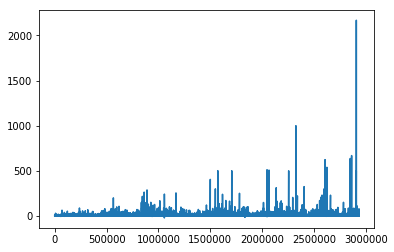

In [38]:
sales['item_cnt_day'].plot()

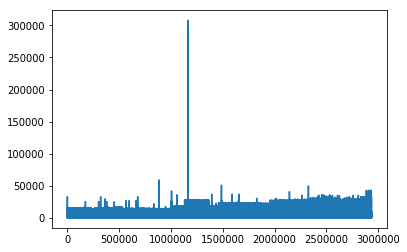

In [39]:
sales['item_price'].plot()

## Remove outliers

In [40]:
sales = sales[sales['item_price'] < 100000]
sales = sales[sales['item_cnt_day'] < 1000]

## Aggregate data

In [41]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# Compute all shop and item combinations
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [42]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


Transform the sales data to be grouped by month and fill missing data with 0

In [43]:
sales_in_month = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()

In [44]:
sales_in_month.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


In [45]:
sales_by_item_id_for_last_val = sales_in_month.groupby('item_id').last()
sales_by_item_id_for_last_val.head()

,date_block_num,shop_id,item_cnt_day,item_price
item_id,,,,
0,20,54,1.0,58.0
1,21,55,1.0,4490.0
2,22,54,1.0,58.0
3,19,54,1.0,58.0
4,20,54,1.0,58.0


In [46]:
month_34_sales = test.copy()

In [47]:
def fill_price(item_id):
    if item_id in sales_by_item_id_for_last_val.index:
        return sales_by_item_id_for_last_val.loc[item_id]['item_price']
    else:
        return sales_by_item_id_for_last_val['item_price'].median()

In [48]:
month_34_sales['date_block_num'] = 34
month_34_sales['item_price'] = month_34_sales['item_id'].apply(fill_price)
month_34_sales['item_cnt_day'] = 0
month_34_sales = month_34_sales.drop(columns=['ID'])

In [49]:
month_34_sales.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,5,5037,34,1499.0,0
1,5,5320,34,299.0,0
2,5,5233,34,1199.0,0
3,5,5232,34,1199.0,0
4,5,5268,34,299.0,0


In [50]:
sales_in_month = pd.merge(grid, sales_in_month, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)

In [51]:
sales_in_month.rename({'item_cnt_day': 'item_cnt_month'}, axis='columns', inplace=True)

In [52]:
month_34_sales.rename({'item_cnt_day': 'item_cnt_month'}, axis='columns', inplace=True)

In [53]:
month_34_sales = month_34_sales.reindex(columns=sales_in_month.columns)

In [54]:
month_34_sales.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price
0,5,5037,34,0,1499.0
1,5,5320,34,0,299.0
2,5,5233,34,0,1199.0
3,5,5232,34,0,1199.0
4,5,5268,34,0,299.0


In [55]:
sales_in_month = sales_in_month.append(month_34_sales)

In [56]:
sales_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


Add item info as well

In [57]:
sales_in_month = pd.merge(sales_in_month, items, on=['item_id'], how='left')

In [58]:
sales_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


# Mean encoding

In [59]:
id_types = ['item_id', 'shop_id', 'item_category_id']
encoding_methods = [('item_price', np.mean, 'mean'), ('item_cnt_day', np.sum, 'sum'), ('item_cnt_day', np.mean, 'mean')]
sales_with_item_info = pd.merge(sales, items, on=['item_id'], how='left')

for id_type in id_types:
    for column_id, agg, agg_type in encoding_methods:
        new_df = sales_with_item_info.groupby([id_type, 'date_block_num']).aggregate(agg).reset_index()[[column_id, id_type, 'date_block_num']]
        new_df.columns = [id_type + '_' + agg_type + '_' + column_id, id_type, 'date_block_num']
        sales_in_month = pd.merge(sales_in_month, new_df, on=['date_block_num', id_type], how='left')

In [60]:
sales_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_id_mean_item_price,item_id_sum_item_cnt_day,item_id_mean_item_cnt_day,shop_id_mean_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_mean_item_price,item_category_id_sum_item_cnt_day,item_category_id_mean_item_cnt_day
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,820.174553,2017.0,1.092041,465.036007,6094.0,1.053414
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,820.174553,2017.0,1.092041,867.446992,268.0,1.007519
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,820.174553,2017.0,1.092041,443.330014,701.0,0.990113


In [61]:
sales_in_month.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price',
       'item_name', 'item_category_id', 'item_id_mean_item_price',
       'item_id_sum_item_cnt_day', 'item_id_mean_item_cnt_day',
       'shop_id_mean_item_price', 'shop_id_sum_item_cnt_day',
       'shop_id_mean_item_cnt_day', 'item_category_id_mean_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_mean_item_cnt_day'],
      dtype='object')

In [62]:
sales_in_month

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_id_mean_item_price,item_id_sum_item_cnt_day,item_id_mean_item_cnt_day,shop_id_mean_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_mean_item_price,item_category_id_sum_item_cnt_day,item_category_id_mean_item_cnt_day
0,59,22154,0,1.0,999.000000,ЯВЛЕНИЕ 2012 (BD),37,999.000000,18.0,1.000000,820.174553,2017.0,1.092041,465.036007,6094.0,1.053414
1,59,2552,0,0.0,0.000000,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.0,0.000000,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
2,59,2554,0,0.0,0.000000,DEEP PURPLE Who Do You Think We Are LP,58,1709.050000,1.0,1.000000,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
3,59,2555,0,0.0,0.000000,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.850000,2.0,1.000000,820.174553,2017.0,1.092041,867.446992,268.0,1.007519
4,59,2564,0,0.0,0.000000,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.600000,5.0,1.000000,820.174553,2017.0,1.092041,443.330014,701.0,0.990113
5,59,2565,0,0.0,0.000000,DEEP PURPLE Stormbringer (фирм.),56,549.000000,2.0,1.000000,820.174553,2017.0,1.092041,867.446992,268.0,1.007519
6,59,2572,0,0.0,0.000000,DEFTONES Koi No Yokan,55,284.333333,12.0,1.000000,820.174553,2017.0,1.092041,265.640547,12527.0,1.025878
7,59,2573,0,0.0,0.000000,DEL REY LANA Born To Die,55,299.000000,16.0,1.142857,820.174553,2017.0,1.092041,265.640547,12527.0,1.025878
8,59,2574,0,2.0,399.000000,DEL REY LANA Born To Die The Paradise Editio...,55,392.986538,119.0,1.144231,820.174553,2017.0,1.092041,265.640547,12527.0,1.025878
9,59,2593,0,0.0,0.000000,DEPECHE MODE Music For The Masses,55,254.200000,5.0,1.000000,820.174553,2017.0,1.092041,265.640547,12527.0,1.025878


# Lag features

In [63]:
lag_features = ['item_id_mean_item_price',
 'item_id_sum_item_cnt_day',
 'item_id_mean_item_cnt_day',
 'shop_id_mean_item_price',
 'shop_id_sum_item_cnt_day',
 'shop_id_mean_item_cnt_day',
 'item_category_id_mean_item_price',
 'item_category_id_sum_item_cnt_day',
 'item_category_id_mean_item_cnt_day',
 'item_cnt_month']

In [64]:
lags = [1, 2, 3, 4, 6, 12]

In [65]:
for lag in lags:
    sales_lags = sales_in_month.copy()
    sales_lags.date_block_num += lag
    sales_lags = sales_lags[['date_block_num','shop_id','item_id'] + lag_features]
    sales_lags.columns = ['date_block_num','shop_id','item_id'] + [lag_feat + '_' + str(lag) + 'months_ago' for lag_feat in lag_features]
    sales_in_month = pd.merge(sales_in_month, sales_lags, on=['date_block_num','shop_id','item_id'], how='left')


In [66]:
for feature in sales_in_month.columns:
    if 'item_cnt' in feature:
        sales_in_month[feature] = sales_in_month[feature].fillna(0)
    elif 'item_price' in feature:
        sales_in_month[feature] = sales_in_month[feature].fillna(sales_in_month[feature].median())

In [67]:
sales_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_id_mean_item_price,item_id_sum_item_cnt_day,item_id_mean_item_cnt_day,...,item_id_mean_item_price_12months_ago,item_id_sum_item_cnt_day_12months_ago,item_id_mean_item_cnt_day_12months_ago,shop_id_mean_item_price_12months_ago,shop_id_sum_item_cnt_day_12months_ago,shop_id_mean_item_cnt_day_12months_ago,item_category_id_mean_item_price_12months_ago,item_category_id_sum_item_cnt_day_12months_ago,item_category_id_mean_item_cnt_day_12months_ago,item_cnt_month_12months_ago
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,...,299.0,0.0,0.0,813.186002,0.0,0.0,364.058483,0.0,0.0,0.0
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,...,299.0,0.0,0.0,813.186002,0.0,0.0,364.058483,0.0,0.0,0.0
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,...,299.0,0.0,0.0,813.186002,0.0,0.0,364.058483,0.0,0.0,0.0
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,...,299.0,0.0,0.0,813.186002,0.0,0.0,364.058483,0.0,0.0,0.0
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,...,299.0,0.0,0.0,813.186002,0.0,0.0,364.058483,0.0,0.0,0.0


In [68]:
sales_in_month.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price',
       'item_name', 'item_category_id', 'item_id_mean_item_price',
       'item_id_sum_item_cnt_day', 'item_id_mean_item_cnt_day',
       'shop_id_mean_item_price', 'shop_id_sum_item_cnt_day',
       'shop_id_mean_item_cnt_day', 'item_category_id_mean_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_mean_item_cnt_day',
       'item_id_mean_item_price_1months_ago',
       'item_id_sum_item_cnt_day_1months_ago',
       'item_id_mean_item_cnt_day_1months_ago',
       'shop_id_mean_item_price_1months_ago',
       'shop_id_sum_item_cnt_day_1months_ago',
       'shop_id_mean_item_cnt_day_1months_ago',
       'item_category_id_mean_item_price_1months_ago',
       'item_category_id_sum_item_cnt_day_1months_ago',
       'item_category_id_mean_item_cnt_day_1months_ago',
       'item_cnt_month_1months_ago', 'item_id_mean_item_price_2months_ago',
       'item_id_sum_item_cnt_day_2months_

Only take recent data

In [69]:
sales_in_month = sales_in_month[sales_in_month['date_block_num'] > 12]

Drop some columns

In [70]:
unused_cols = lag_features[:-1] + ['item_name', 'item_price']

Clipping target values

In [71]:
sales_in_month['item_cnt_month'] = sales_in_month['item_cnt_month'].clip(0, 40)

# Split into training and validation sets

In [72]:
X_train = sales_in_month[sales_in_month['date_block_num'] < 33].drop(unused_cols, axis=1)
X_cv = sales_in_month[sales_in_month['date_block_num'] == 33].drop(unused_cols, axis=1)
X_test = sales_in_month[sales_in_month['date_block_num'] == 34].drop(unused_cols, axis=1)

In [73]:
X_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_id_mean_item_price_1months_ago,item_id_sum_item_cnt_day_1months_ago,item_id_mean_item_cnt_day_1months_ago,shop_id_mean_item_price_1months_ago,shop_id_sum_item_cnt_day_1months_ago,...,item_id_mean_item_price_12months_ago,item_id_sum_item_cnt_day_12months_ago,item_id_mean_item_cnt_day_12months_ago,shop_id_mean_item_price_12months_ago,shop_id_sum_item_cnt_day_12months_ago,shop_id_mean_item_cnt_day_12months_ago,item_category_id_mean_item_price_12months_ago,item_category_id_sum_item_cnt_day_12months_ago,item_category_id_mean_item_cnt_day_12months_ago,item_cnt_month_12months_ago
4836056,27,15242,13,2.0,63,670.333333,9.0,1.000000,933.352539,5451.0,...,299.0,0.0,0.0,813.186002,0.0,0.000000,364.058483,0.0,0.000000,0.0
4836057,27,15200,13,1.0,69,499.000000,1.0,1.000000,933.352539,5451.0,...,299.0,0.0,0.0,813.186002,0.0,0.000000,364.058483,0.0,0.000000,0.0
4836058,27,15279,13,2.0,63,798.112222,48.0,1.066667,933.352539,5451.0,...,299.0,0.0,0.0,813.186002,0.0,0.000000,364.058483,0.0,0.000000,0.0
4836059,27,15202,13,1.0,69,499.000000,2.0,1.000000,933.352539,5451.0,...,499.0,5.0,1.0,820.297558,4546.0,1.206155,703.047327,503.0,1.120267,0.0
4836060,27,14888,13,1.0,55,549.000000,21.0,1.000000,933.352539,5451.0,...,299.0,0.0,0.0,813.186002,0.0,0.000000,364.058483,0.0,0.000000,0.0


In [74]:
X_cv.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_id_mean_item_price_1months_ago,item_id_sum_item_cnt_day_1months_ago,item_id_mean_item_cnt_day_1months_ago,shop_id_mean_item_price_1months_ago,shop_id_sum_item_cnt_day_1months_ago,...,item_id_mean_item_price_12months_ago,item_id_sum_item_cnt_day_12months_ago,item_id_mean_item_cnt_day_12months_ago,shop_id_mean_item_price_12months_ago,shop_id_sum_item_cnt_day_12months_ago,shop_id_mean_item_cnt_day_12months_ago,item_category_id_mean_item_price_12months_ago,item_category_id_sum_item_cnt_day_12months_ago,item_category_id_mean_item_cnt_day_12months_ago,item_cnt_month_12months_ago
10675632,45,13315,33,1.0,47,649.000000,1.0,1.000000,1290.294631,654.0,...,299.000000,0.0,0.000000,813.186002,0.0,0.000000,364.058483,0.0,0.000000,0.0
10675633,45,13880,33,1.0,55,225.037037,57.0,1.055556,1290.294631,654.0,...,199.000000,14.0,1.000000,1163.839653,933.0,1.245661,302.332107,9179.0,1.020229,0.0
10675634,45,13881,33,2.0,55,647.991212,34.0,1.030303,1290.294631,654.0,...,598.991429,79.0,1.128571,1163.839653,933.0,1.245661,302.332107,9179.0,1.020229,2.0
10675635,45,13923,33,1.0,40,158.952667,15.0,1.000000,1290.294631,654.0,...,148.971429,21.0,1.000000,1163.839653,933.0,1.245661,263.751745,13639.0,1.088073,1.0
10675636,45,14227,33,1.0,30,95.542317,89.0,1.085366,1290.294631,654.0,...,97.730106,101.0,1.074468,1163.839653,933.0,1.245661,651.950501,14655.0,1.482549,1.0


In [75]:
X_test.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_id_mean_item_price_1months_ago,item_id_sum_item_cnt_day_1months_ago,item_id_mean_item_cnt_day_1months_ago,shop_id_mean_item_price_1months_ago,shop_id_sum_item_cnt_day_1months_ago,...,item_id_mean_item_price_12months_ago,item_id_sum_item_cnt_day_12months_ago,item_id_mean_item_cnt_day_12months_ago,shop_id_mean_item_price_12months_ago,shop_id_sum_item_cnt_day_12months_ago,shop_id_mean_item_cnt_day_12months_ago,item_category_id_mean_item_price_12months_ago,item_category_id_sum_item_cnt_day_12months_ago,item_category_id_mean_item_cnt_day_12months_ago,item_cnt_month_12months_ago
10913804,5,5037,34,0.0,19,1499.000000,25.0,1.000000,1030.721934,1052.0,...,2569.619846,65.0,1.0,1175.319266,1445.0,1.235043,1800.733280,6134.0,1.144403,1.0
10913805,5,5320,34,0.0,55,299.000000,0.0,0.000000,885.712018,0.0,...,299.000000,0.0,0.0,813.186002,0.0,0.000000,364.058483,0.0,0.000000,0.0
10913806,5,5233,34,0.0,19,1199.000000,42.0,1.024390,1030.721934,1052.0,...,299.000000,0.0,0.0,813.186002,0.0,0.000000,364.058483,0.0,0.000000,0.0
10913807,5,5232,34,0.0,23,1190.433333,28.0,0.933333,1030.721934,1052.0,...,299.000000,0.0,0.0,813.186002,0.0,0.000000,364.058483,0.0,0.000000,0.0
10913808,5,5268,34,0.0,20,299.000000,0.0,0.000000,885.712018,0.0,...,299.000000,0.0,0.0,813.186002,0.0,0.000000,364.058483,0.0,0.000000,0.0


In [80]:
X_train.to_csv('./data/X_train.csv', index=False)
X_cv.to_csv('./data/X_cv.csv', index=False)

X_test = X_test.reindex(columns=X_cv.columns)
X_test = X_test.drop('item_cnt_month', 1)
X_test.to_csv('./data/X_test.csv', index=False)

## Reload training and testing data

In [3]:
X_train = pd.read_csv('./data/X_train.csv')
X_cv = pd.read_csv('./data/X_cv.csv')
X_test_features = pd.read_csv('./data/X_test.csv')

In [4]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error
from math import sqrt

In [5]:
X_train_features = X_train.drop('item_cnt_month', 1)
y_train = X_train['item_cnt_month']
X_cv_features = X_cv.drop('item_cnt_month', 1)
y_cv = X_cv['item_cnt_month']

# Hyperparameter tuning

In [10]:
best_3 = []
count = 0
best = None

In [11]:
def train(params):
    global best_3, count
    params['max_depth'] = int(params['max_depth'])

    train_set = xgb.DMatrix(X_train_features, label=y_train)
    validation_set = xgb.DMatrix(X_cv_features, label=y_cv)

    watchlist = [(train_set, 'train'), (validation_set, 'validation')]
    model = xgb.train(params, train_set, 500, evals=watchlist, verbose_eval=True, early_stopping_rounds=50)
    predictions = model.predict(validation_set, ntree_limit=model.best_iteration + 1)
    loss = sqrt(mean_squared_error(y_cv, predictions))
    
    if loss not in [best_model['loss'] for best_model in best_3]:
        best_3.append({ 'model': model, 'loss': loss })
    
    best_3 = sorted(best_3, key=lambda x: x['loss'])[:3]
    count += 1
    
    print(count)
    print("Trained with:")
    print(params)
    print("Loss:")
    print(loss)
    return { 'loss': loss, 'status': STATUS_OK }

In [12]:
seed = 20

def optimize():
    global best
    
    space = {
             'max_depth' : hp.quniform('max_depth', 5, 9, 1),
             'eta' : hp.quniform('eta', 0.07, 0.1, 0.01),
             'gamma' : hp.quniform('gamma', 0.8, 1.1, 0.1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 4, 1),
             'eval_metric': 'rmse',
             'objective': 'reg:linear',
             'tree_method': 'exact',
             'silent' : 1,
             'seed': seed
             }

    trials = Trials()
    best = fmin(train, space, algo=tpe.suggest, max_evals=15, trials=trials)

    print(best)

In [13]:
optimize()

[0]	train-rmse:1.39922	validation-rmse:1.37408
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 50 rounds.
[1]	train-rmse:1.35179	validation-rmse:1.3387
[2]	train-rmse:1.3109	validation-rmse:1.3085
[3]	train-rmse:1.27542	validation-rmse:1.28275
[4]	train-rmse:1.24449	validation-rmse:1.26087
[5]	train-rmse:1.21836	validation-rmse:1.24319
[6]	train-rmse:1.19535	validation-rmse:1.22807
[7]	train-rmse:1.17603	validation-rmse:1.21553
[8]	train-rmse:1.15923	validation-rmse:1.20526
[9]	train-rmse:1.14413	validation-rmse:1.19573
[10]	train-rmse:1.13159	validation-rmse:1.18833
[11]	train-rmse:1.119	validation-rmse:1.17952
[12]	train-rmse:1.10904	validation-rmse:1.17439
[13]	train-rmse:1.10093	validation-rmse:1.16902
[14]	train-rmse:1.09182	validation-rmse:1.16243
[15]	train-rmse:1.08434	validation-rmse:1.15816
[16]	train-rmse:1.07768	validation-rmse:1.1545
[17]	train-rmse:1.07222	validation-rmse:1.152

[165]	train-rmse:0.929099	validation-rmse:1.12819
[166]	train-rmse:0.928781	validation-rmse:1.12815
[167]	train-rmse:0.928064	validation-rmse:1.12747
[168]	train-rmse:0.927845	validation-rmse:1.12755
[169]	train-rmse:0.927591	validation-rmse:1.12744
[170]	train-rmse:0.92733	validation-rmse:1.12732
[171]	train-rmse:0.926696	validation-rmse:1.12756
[172]	train-rmse:0.926395	validation-rmse:1.1275
[173]	train-rmse:0.926115	validation-rmse:1.1275
[174]	train-rmse:0.925666	validation-rmse:1.12743
[175]	train-rmse:0.925061	validation-rmse:1.12708
[176]	train-rmse:0.924888	validation-rmse:1.12733
[177]	train-rmse:0.92474	validation-rmse:1.12725
[178]	train-rmse:0.924664	validation-rmse:1.12715
[179]	train-rmse:0.924492	validation-rmse:1.12702
[180]	train-rmse:0.922783	validation-rmse:1.128
[181]	train-rmse:0.922675	validation-rmse:1.128
[182]	train-rmse:0.921542	validation-rmse:1.13079
[183]	train-rmse:0.920932	validation-rmse:1.13085
[184]	train-rmse:0.920808	validation-rmse:1.13081
[185]	tr

[137]	train-rmse:1.00685	validation-rmse:1.12871
[138]	train-rmse:1.00667	validation-rmse:1.1287
[139]	train-rmse:1.00649	validation-rmse:1.12863
[140]	train-rmse:1.00633	validation-rmse:1.12861
[141]	train-rmse:1.00598	validation-rmse:1.1286
[142]	train-rmse:1.00542	validation-rmse:1.12848
[143]	train-rmse:1.00521	validation-rmse:1.12851
[144]	train-rmse:1.00494	validation-rmse:1.12844
[145]	train-rmse:1.00486	validation-rmse:1.12844
[146]	train-rmse:1.00448	validation-rmse:1.12794
[147]	train-rmse:1.00418	validation-rmse:1.12788
[148]	train-rmse:1.00392	validation-rmse:1.12805
[149]	train-rmse:1.00362	validation-rmse:1.12838
[150]	train-rmse:1.0034	validation-rmse:1.12829
[151]	train-rmse:1.00315	validation-rmse:1.12814
[152]	train-rmse:1.00288	validation-rmse:1.12825
[153]	train-rmse:1.00272	validation-rmse:1.12828
[154]	train-rmse:1.00234	validation-rmse:1.12825
[155]	train-rmse:1.00208	validation-rmse:1.12816
[156]	train-rmse:1.00183	validation-rmse:1.12839
[157]	train-rmse:1.0011

[57]	train-rmse:0.967215	validation-rmse:1.12882
[58]	train-rmse:0.965864	validation-rmse:1.12759
[59]	train-rmse:0.96465	validation-rmse:1.12757
[60]	train-rmse:0.964131	validation-rmse:1.12776
[61]	train-rmse:0.962919	validation-rmse:1.12705
[62]	train-rmse:0.962431	validation-rmse:1.12707
[63]	train-rmse:0.959916	validation-rmse:1.12563
[64]	train-rmse:0.958454	validation-rmse:1.12511
[65]	train-rmse:0.957903	validation-rmse:1.12522
[66]	train-rmse:0.95747	validation-rmse:1.12486
[67]	train-rmse:0.956961	validation-rmse:1.12476
[68]	train-rmse:0.954227	validation-rmse:1.12493
[69]	train-rmse:0.953706	validation-rmse:1.125
[70]	train-rmse:0.952447	validation-rmse:1.12443
[71]	train-rmse:0.951524	validation-rmse:1.12522
[72]	train-rmse:0.951162	validation-rmse:1.12522
[73]	train-rmse:0.950676	validation-rmse:1.12519
[74]	train-rmse:0.949255	validation-rmse:1.12515
[75]	train-rmse:0.948579	validation-rmse:1.12499
[76]	train-rmse:0.947856	validation-rmse:1.1247
[77]	train-rmse:0.947569	

[73]	train-rmse:0.979001	validation-rmse:1.12927
[74]	train-rmse:0.978591	validation-rmse:1.12906
[75]	train-rmse:0.977769	validation-rmse:1.12906
[76]	train-rmse:0.975066	validation-rmse:1.13174
[77]	train-rmse:0.974563	validation-rmse:1.13171
[78]	train-rmse:0.972885	validation-rmse:1.13136
[79]	train-rmse:0.972127	validation-rmse:1.13161
[80]	train-rmse:0.971601	validation-rmse:1.13155
[81]	train-rmse:0.971178	validation-rmse:1.13148
[82]	train-rmse:0.970108	validation-rmse:1.13134
[83]	train-rmse:0.969805	validation-rmse:1.13118
[84]	train-rmse:0.96897	validation-rmse:1.13081
[85]	train-rmse:0.968652	validation-rmse:1.13067
[86]	train-rmse:0.968215	validation-rmse:1.1307
[87]	train-rmse:0.967703	validation-rmse:1.13044
[88]	train-rmse:0.967392	validation-rmse:1.13022
[89]	train-rmse:0.966899	validation-rmse:1.13005
[90]	train-rmse:0.966424	validation-rmse:1.12971
[91]	train-rmse:0.966054	validation-rmse:1.12968
[92]	train-rmse:0.965773	validation-rmse:1.12935
[93]	train-rmse:0.9653

[76]	train-rmse:1.00605	validation-rmse:1.13043
[77]	train-rmse:1.00546	validation-rmse:1.13039
[78]	train-rmse:1.00464	validation-rmse:1.12994
[79]	train-rmse:1.00343	validation-rmse:1.13011
[80]	train-rmse:1.00304	validation-rmse:1.13004
[81]	train-rmse:1.00218	validation-rmse:1.13001
[82]	train-rmse:1.00169	validation-rmse:1.12954
[83]	train-rmse:1.00101	validation-rmse:1.12958
[84]	train-rmse:1.00047	validation-rmse:1.12958
[85]	train-rmse:1.00004	validation-rmse:1.12913
[86]	train-rmse:0.999391	validation-rmse:1.12875
[87]	train-rmse:0.998715	validation-rmse:1.12896
[88]	train-rmse:0.998252	validation-rmse:1.12878
[89]	train-rmse:0.997901	validation-rmse:1.12882
[90]	train-rmse:0.997547	validation-rmse:1.12855
[91]	train-rmse:0.997352	validation-rmse:1.12856
[92]	train-rmse:0.996923	validation-rmse:1.12855
[93]	train-rmse:0.996528	validation-rmse:1.12836
[94]	train-rmse:0.996049	validation-rmse:1.12795
[95]	train-rmse:0.995792	validation-rmse:1.12801
[96]	train-rmse:0.995317	valid

[31]	train-rmse:1.03693	validation-rmse:1.14014
[32]	train-rmse:1.03501	validation-rmse:1.14044
[33]	train-rmse:1.03334	validation-rmse:1.13993
[34]	train-rmse:1.03194	validation-rmse:1.13992
[35]	train-rmse:1.03047	validation-rmse:1.13998
[36]	train-rmse:1.02907	validation-rmse:1.14054
[37]	train-rmse:1.02621	validation-rmse:1.13861
[38]	train-rmse:1.02519	validation-rmse:1.13875
[39]	train-rmse:1.02434	validation-rmse:1.13854
[40]	train-rmse:1.02255	validation-rmse:1.13827
[41]	train-rmse:1.02019	validation-rmse:1.13676
[42]	train-rmse:1.01877	validation-rmse:1.13661
[43]	train-rmse:1.01767	validation-rmse:1.13642
[44]	train-rmse:1.01627	validation-rmse:1.13632
[45]	train-rmse:1.01535	validation-rmse:1.13641
[46]	train-rmse:1.01444	validation-rmse:1.13596
[47]	train-rmse:1.01366	validation-rmse:1.13572
[48]	train-rmse:1.01253	validation-rmse:1.13545
[49]	train-rmse:1.0116	validation-rmse:1.13538
[50]	train-rmse:1.01005	validation-rmse:1.13456
[51]	train-rmse:1.0093	validation-rmse:1.

[34]	train-rmse:1.05906	validation-rmse:1.14919
[35]	train-rmse:1.05786	validation-rmse:1.14904
[36]	train-rmse:1.05682	validation-rmse:1.1486
[37]	train-rmse:1.05583	validation-rmse:1.14837
[38]	train-rmse:1.05463	validation-rmse:1.14776
[39]	train-rmse:1.05372	validation-rmse:1.14794
[40]	train-rmse:1.05252	validation-rmse:1.14745
[41]	train-rmse:1.05157	validation-rmse:1.14725
[42]	train-rmse:1.04922	validation-rmse:1.14571
[43]	train-rmse:1.04792	validation-rmse:1.14537
[44]	train-rmse:1.04716	validation-rmse:1.14522
[45]	train-rmse:1.04629	validation-rmse:1.14519
[46]	train-rmse:1.04448	validation-rmse:1.14361
[47]	train-rmse:1.04353	validation-rmse:1.1434
[48]	train-rmse:1.04234	validation-rmse:1.14251
[49]	train-rmse:1.0407	validation-rmse:1.1422
[50]	train-rmse:1.04005	validation-rmse:1.14155
[51]	train-rmse:1.03807	validation-rmse:1.14023
[52]	train-rmse:1.03582	validation-rmse:1.13821
[53]	train-rmse:1.03453	validation-rmse:1.13766
[54]	train-rmse:1.03373	validation-rmse:1.13

[202]	train-rmse:0.962633	validation-rmse:1.12659
[203]	train-rmse:0.962328	validation-rmse:1.12636
[204]	train-rmse:0.962126	validation-rmse:1.12613
[205]	train-rmse:0.961894	validation-rmse:1.12603
[206]	train-rmse:0.961743	validation-rmse:1.12605
[207]	train-rmse:0.96157	validation-rmse:1.12604
[208]	train-rmse:0.961243	validation-rmse:1.12604
[209]	train-rmse:0.960804	validation-rmse:1.12598
[210]	train-rmse:0.960529	validation-rmse:1.12585
[211]	train-rmse:0.96038	validation-rmse:1.12585
[212]	train-rmse:0.960259	validation-rmse:1.12584
[213]	train-rmse:0.960182	validation-rmse:1.12582
[214]	train-rmse:0.959897	validation-rmse:1.12562
[215]	train-rmse:0.959618	validation-rmse:1.12546
[216]	train-rmse:0.959424	validation-rmse:1.12541
[217]	train-rmse:0.959322	validation-rmse:1.12543
[218]	train-rmse:0.959203	validation-rmse:1.12529
[219]	train-rmse:0.959108	validation-rmse:1.12529
[220]	train-rmse:0.958969	validation-rmse:1.12528
[221]	train-rmse:0.958635	validation-rmse:1.12494
[2

[129]	train-rmse:0.958283	validation-rmse:1.12193
[130]	train-rmse:0.957941	validation-rmse:1.12195
[131]	train-rmse:0.957507	validation-rmse:1.1223
[132]	train-rmse:0.957136	validation-rmse:1.12241
[133]	train-rmse:0.956993	validation-rmse:1.12237
[134]	train-rmse:0.956594	validation-rmse:1.12246
[135]	train-rmse:0.955989	validation-rmse:1.12208
[136]	train-rmse:0.955713	validation-rmse:1.12201
[137]	train-rmse:0.954544	validation-rmse:1.12189
[138]	train-rmse:0.954317	validation-rmse:1.12179
[139]	train-rmse:0.954007	validation-rmse:1.12199
[140]	train-rmse:0.95387	validation-rmse:1.12193
[141]	train-rmse:0.953669	validation-rmse:1.122
[142]	train-rmse:0.952303	validation-rmse:1.12186
[143]	train-rmse:0.950824	validation-rmse:1.12287
[144]	train-rmse:0.950525	validation-rmse:1.12284
[145]	train-rmse:0.950369	validation-rmse:1.12293
[146]	train-rmse:0.949653	validation-rmse:1.122
[147]	train-rmse:0.949256	validation-rmse:1.12205
[148]	train-rmse:0.949126	validation-rmse:1.12199
[149]	

[2]	train-rmse:1.3196	validation-rmse:1.31627
[3]	train-rmse:1.28369	validation-rmse:1.28901
[4]	train-rmse:1.25312	validation-rmse:1.26769
[5]	train-rmse:1.22633	validation-rmse:1.24968
[6]	train-rmse:1.20261	validation-rmse:1.23403
[7]	train-rmse:1.18171	validation-rmse:1.22035
[8]	train-rmse:1.1632	validation-rmse:1.2089
[9]	train-rmse:1.14728	validation-rmse:1.19962
[10]	train-rmse:1.13291	validation-rmse:1.19159
[11]	train-rmse:1.11867	validation-rmse:1.18198
[12]	train-rmse:1.1067	validation-rmse:1.17412
[13]	train-rmse:1.09654	validation-rmse:1.16881
[14]	train-rmse:1.08649	validation-rmse:1.16296
[15]	train-rmse:1.07853	validation-rmse:1.15927
[16]	train-rmse:1.07067	validation-rmse:1.15548
[17]	train-rmse:1.06454	validation-rmse:1.15333
[18]	train-rmse:1.0572	validation-rmse:1.14907
[19]	train-rmse:1.0514	validation-rmse:1.14618
[20]	train-rmse:1.04622	validation-rmse:1.14393
[21]	train-rmse:1.04143	validation-rmse:1.142
[22]	train-rmse:1.0374	validation-rmse:1.14074
[23]	trai

Will train until validation-rmse hasn't improved in 50 rounds.
[1]	train-rmse:1.34786	validation-rmse:1.33747
[2]	train-rmse:1.3055	validation-rmse:1.30647
[3]	train-rmse:1.26792	validation-rmse:1.2794
[4]	train-rmse:1.23555	validation-rmse:1.25797
[5]	train-rmse:1.20779	validation-rmse:1.23937
[6]	train-rmse:1.18382	validation-rmse:1.22328
[7]	train-rmse:1.16336	validation-rmse:1.21071
[8]	train-rmse:1.14541	validation-rmse:1.19931
[9]	train-rmse:1.12806	validation-rmse:1.18668
[10]	train-rmse:1.11328	validation-rmse:1.17692
[11]	train-rmse:1.10018	validation-rmse:1.16803
[12]	train-rmse:1.08945	validation-rmse:1.16261
[13]	train-rmse:1.08004	validation-rmse:1.15785
[14]	train-rmse:1.07191	validation-rmse:1.15372
[15]	train-rmse:1.06342	validation-rmse:1.14969
[16]	train-rmse:1.05563	validation-rmse:1.14625
[17]	train-rmse:1.04941	validation-rmse:1.14319
[18]	train-rmse:1.04433	validation-rmse:1.14136
[19]	train-rmse:1.03873	validation-rmse:1.13914
[20]	train-rmse:1.03382	validation-r

[0]	train-rmse:1.40339	validation-rmse:1.37807
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 50 rounds.
[1]	train-rmse:1.35861	validation-rmse:1.34536
[2]	train-rmse:1.31956	validation-rmse:1.31666
[3]	train-rmse:1.28351	validation-rmse:1.28936
[4]	train-rmse:1.25279	validation-rmse:1.26894
[5]	train-rmse:1.22577	validation-rmse:1.25035
[6]	train-rmse:1.20243	validation-rmse:1.23554
[7]	train-rmse:1.18159	validation-rmse:1.22232
[8]	train-rmse:1.16302	validation-rmse:1.21002
[9]	train-rmse:1.14693	validation-rmse:1.20048
[10]	train-rmse:1.13125	validation-rmse:1.18959
[11]	train-rmse:1.11717	validation-rmse:1.18003
[12]	train-rmse:1.105	validation-rmse:1.17215
[13]	train-rmse:1.0939	validation-rmse:1.16556
[14]	train-rmse:1.08474	validation-rmse:1.16102
[15]	train-rmse:1.07687	validation-rmse:1.1571
[16]	train-rmse:1.06893	validation-rmse:1.15345
[17]	train-rmse:1.06274	validation-rmse:1.1

[0]	train-rmse:1.40953	validation-rmse:1.38234
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 50 rounds.
[1]	train-rmse:1.36958	validation-rmse:1.35298
[2]	train-rmse:1.33423	validation-rmse:1.32684
[3]	train-rmse:1.30194	validation-rmse:1.30347
[4]	train-rmse:1.27329	validation-rmse:1.28289
[5]	train-rmse:1.24742	validation-rmse:1.26493
[6]	train-rmse:1.22462	validation-rmse:1.24942
[7]	train-rmse:1.20293	validation-rmse:1.23363
[8]	train-rmse:1.18479	validation-rmse:1.22253
[9]	train-rmse:1.16696	validation-rmse:1.2093
[10]	train-rmse:1.15237	validation-rmse:1.2005
[11]	train-rmse:1.13925	validation-rmse:1.19274
[12]	train-rmse:1.12726	validation-rmse:1.18522
[13]	train-rmse:1.11575	validation-rmse:1.17756
[14]	train-rmse:1.10516	validation-rmse:1.1706
[15]	train-rmse:1.09645	validation-rmse:1.16585
[16]	train-rmse:1.08795	validation-rmse:1.16083
[17]	train-rmse:1.08017	validation-rmse:1.

[165]	train-rmse:0.913674	validation-rmse:1.12258
[166]	train-rmse:0.913471	validation-rmse:1.1223
[167]	train-rmse:0.913236	validation-rmse:1.12254
[168]	train-rmse:0.910796	validation-rmse:1.12417
[169]	train-rmse:0.91032	validation-rmse:1.12399
[170]	train-rmse:0.91024	validation-rmse:1.12399
[171]	train-rmse:0.909927	validation-rmse:1.12377
[172]	train-rmse:0.909726	validation-rmse:1.12372
[173]	train-rmse:0.909472	validation-rmse:1.12451
[174]	train-rmse:0.909323	validation-rmse:1.12455
[175]	train-rmse:0.909037	validation-rmse:1.12448
[176]	train-rmse:0.908869	validation-rmse:1.12443
[177]	train-rmse:0.908582	validation-rmse:1.1243
[178]	train-rmse:0.908429	validation-rmse:1.12401
[179]	train-rmse:0.90829	validation-rmse:1.1239
[180]	train-rmse:0.907919	validation-rmse:1.1239
[181]	train-rmse:0.907484	validation-rmse:1.12383
[182]	train-rmse:0.90731	validation-rmse:1.12377
[183]	train-rmse:0.904479	validation-rmse:1.12531
[184]	train-rmse:0.904332	validation-rmse:1.12528
[185]	tr

[131]	train-rmse:0.973735	validation-rmse:1.12835
[132]	train-rmse:0.973367	validation-rmse:1.1281
[133]	train-rmse:0.973126	validation-rmse:1.12793
[134]	train-rmse:0.97257	validation-rmse:1.12732
[135]	train-rmse:0.972208	validation-rmse:1.12727
[136]	train-rmse:0.9711	validation-rmse:1.12659
[137]	train-rmse:0.970846	validation-rmse:1.12632
[138]	train-rmse:0.970571	validation-rmse:1.12622
[139]	train-rmse:0.970295	validation-rmse:1.12631
[140]	train-rmse:0.969832	validation-rmse:1.12626
[141]	train-rmse:0.969277	validation-rmse:1.12579
[142]	train-rmse:0.969149	validation-rmse:1.12583
[143]	train-rmse:0.968841	validation-rmse:1.1263
[144]	train-rmse:0.96854	validation-rmse:1.12648
[145]	train-rmse:0.96824	validation-rmse:1.12608
[146]	train-rmse:0.967588	validation-rmse:1.12635
[147]	train-rmse:0.967378	validation-rmse:1.12625
[148]	train-rmse:0.967187	validation-rmse:1.1261
[149]	train-rmse:0.967119	validation-rmse:1.12577
[150]	train-rmse:0.966996	validation-rmse:1.1257
[151]	tra

[71]	train-rmse:1.03754	validation-rmse:1.13459
[72]	train-rmse:1.03698	validation-rmse:1.13442
[73]	train-rmse:1.03632	validation-rmse:1.13421
[74]	train-rmse:1.03597	validation-rmse:1.13432
[75]	train-rmse:1.03558	validation-rmse:1.13484
[76]	train-rmse:1.0351	validation-rmse:1.13435
[77]	train-rmse:1.03484	validation-rmse:1.13428
[78]	train-rmse:1.03425	validation-rmse:1.13369
[79]	train-rmse:1.03409	validation-rmse:1.13368
[80]	train-rmse:1.03228	validation-rmse:1.13258
[81]	train-rmse:1.03208	validation-rmse:1.13258
[82]	train-rmse:1.03193	validation-rmse:1.13255
[83]	train-rmse:1.03085	validation-rmse:1.13213
[84]	train-rmse:1.03007	validation-rmse:1.13153
[85]	train-rmse:1.02899	validation-rmse:1.13106
[86]	train-rmse:1.02874	validation-rmse:1.13109
[87]	train-rmse:1.02811	validation-rmse:1.13139
[88]	train-rmse:1.02738	validation-rmse:1.13077
[89]	train-rmse:1.02722	validation-rmse:1.13062
[90]	train-rmse:1.02705	validation-rmse:1.13062
[91]	train-rmse:1.02649	validation-rmse:1

[34]	train-rmse:1.05503	validation-rmse:1.14988
[35]	train-rmse:1.05126	validation-rmse:1.1461
[36]	train-rmse:1.04965	validation-rmse:1.14554
[37]	train-rmse:1.04838	validation-rmse:1.14585
[38]	train-rmse:1.04755	validation-rmse:1.14558
[39]	train-rmse:1.04682	validation-rmse:1.14532
[40]	train-rmse:1.04562	validation-rmse:1.14509
[41]	train-rmse:1.04482	validation-rmse:1.14495
[42]	train-rmse:1.04292	validation-rmse:1.14284
[43]	train-rmse:1.04217	validation-rmse:1.14257
[44]	train-rmse:1.03968	validation-rmse:1.14051
[45]	train-rmse:1.03896	validation-rmse:1.14061
[46]	train-rmse:1.03788	validation-rmse:1.13986
[47]	train-rmse:1.03652	validation-rmse:1.1392
[48]	train-rmse:1.03471	validation-rmse:1.13894
[49]	train-rmse:1.0332	validation-rmse:1.13888
[50]	train-rmse:1.03034	validation-rmse:1.13702
[51]	train-rmse:1.02924	validation-rmse:1.13629
[52]	train-rmse:1.02787	validation-rmse:1.13549
[53]	train-rmse:1.02697	validation-rmse:1.13483
[54]	train-rmse:1.02626	validation-rmse:1.1

In [16]:
import joblib

In [17]:
joblib.dump(best_3[0], 'model_1')
joblib.dump(best_3[1], 'model_2') 
joblib.dump(best_3[2], 'model_3')

['model_3']

In [18]:
best_3

[{'model': <xgboost.core.Booster at 0x10e531dd8>, 'loss': 1.1179769195963845},
 {'model': <xgboost.core.Booster at 0x10e531e80>, 'loss': 1.1204713029384652},
 {'model': <xgboost.core.Booster at 0x10e531e10>, 'loss': 1.1206105592334732}]

## Reload models and test data

In [21]:
import joblib
import xgboost as xgb

In [22]:
X_cv_features = pd.read_csv('./data/X_cv.csv').drop('item_cnt_month', 1)
X_test_features = pd.read_csv('./data/X_test.csv').reindex(columns=X_cv_features.columns)
raw_test = pd.read_csv('./data/test.csv.gz')
best_3 = [
    joblib.load('./models/model_1'),
    joblib.load('./models/model_2'),
    joblib.load('./models/model_3'),
]

# Ensembling

In [23]:
def predict_test(model):
    test = xgb.DMatrix(X_test_features)
    return model.predict(test, ntree_limit=model.best_iteration + 1)

In [24]:
first_preds = predict_test(best_3[0]['model'])
second_preds = predict_test(best_3[1]['model'])
third_preds = predict_test(best_3[2]['model'])

In [25]:
final_preds = np.array([first_preds, second_preds, third_preds]).mean(axis=0)

In [26]:
subs = raw_test.copy()

In [27]:
subs['item_cnt_month'] = final_preds.clip(0, 20)

In [28]:
subs['item_cnt_month'] = subs['item_cnt_month']

In [29]:
submission = subs[['ID', 'item_cnt_month']]

In [30]:
submission.head()

,ID,item_cnt_month
0,0,0.452183
1,1,0.222075
2,2,1.051951
3,3,0.332675
4,4,3.982105


In [31]:
submission.to_csv('./data/subs.csv', index=False)